we start with 3204769 transcripts, only 532080 transcripts that were assigned to our polygons
from xenium we know that they detected 216323 cells, we detected 147344 or 83947 after processing (including filtering of 4489, because polygon was not uniquely mapped to a cell)

In [1]:
import sys
sys.path.append('utils')
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2024-09-02 07:38:19.960299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gdf = gpd.read_file('../data/xenium/stardist_buffered_07_voronoi.geojson')
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]
gdf.crs = None
gdf

id                                           geometry
0              ID_1  POLYGON ((2064.585 346.259, 2064.443 347.150, ...
1              ID_2  POLYGON ((2948.857 2708.953, 2948.857 2708.953...
2              ID_3  POLYGON ((2913.311 3155.884, 2913.176 3156.081...
3              ID_4  POLYGON ((3070.291 3509.373, 3070.743 3508.136...
4              ID_5  POLYGON ((2971.461 3522.759, 2972.994 3522.979...
...             ...                                                ...
1070693  ID_1070694  POLYGON ((27610.110 20999.249, 27609.944 20999...
1070694  ID_1070695  POLYGON ((29116.243 23960.325, 29116.253 23960...
1070695  ID_1070696  POLYGON ((30577.852 22831.596, 30577.924 22832...
1070696  ID_1070697  POLYGON ((27639.895 21196.146, 27639.631 21196...
1070697  ID_1070698  POLYGON ((27804.946 21286.217, 27804.171 21286...

[1070698 rows x 2 columns]

In [3]:
import scanpy as sc
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')
adata

AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [4]:
adata_df = adata.to_df()

In [5]:
df_tissue_positions = adata_df
df_tissue_positions['index']=df_tissue_positions.index

In [6]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(adata.obs['center_x'], adata.obs['center_y'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [7]:
gdf.crs = None

In [8]:
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

In [9]:
# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()

In [10]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon']==True]


In [11]:
barcodes_in_one_polygon.shape

(7037998, 546)

In [12]:
# Convert the tuples in barcodes_in_one_polygon['index'] to strings
barcodes_in_one_polygon['index'] = barcodes_in_one_polygon['index'].apply(lambda x: str(x))

# If you want to remove the 'bin' index name and set it as a regular column
barcodes_in_one_polygon.reset_index(inplace=True, drop=True)

geodataframe.py (1528): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

In [14]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])

In [15]:
filtered_adata = adata[filtered_obs_mask,:]

In [16]:
filtered_adata

View of AnnData object with n_obs × n_vars = 573370 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [17]:
print(f"Length of filtered_adata.obs: {len(filtered_adata.obs)}")
print(f"Length of barcodes_in_one_polygon: {len(barcodes_in_one_polygon)}")

Length of filtered_adata.obs: 573370
Length of barcodes_in_one_polygon: 573370


In [18]:
print(filtered_adata.obs.index[:5])  # Print first few indices from filtered_adata.obs
print(barcodes_in_one_polygon['index'][:5])  # Print first few indices from barcodes_in_one_polygon

Index(['(1, 1253)', '(1, 1359)', '(1, 1360)', '(1, 1362)', '(1, 1538)'], dtype='object', name='bin')
bin
(1, 1253)    (1, 1253)
(1, 1359)    (1, 1359)
(1, 1360)    (1, 1360)
(1, 1362)    (1, 1362)
(1, 1538)    (1, 1538)
Name: index, dtype: object


In [19]:

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry', 'id', 'is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


In [20]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(1, 1253)    sample1   5987.326733  18533.612073   5996.738498  18543.023838  \
(1, 1359)    sample1   5987.326733  19531.259132   5996.738498  19540.670896   
(1, 1360)    sample1   5987.326733  19540.670896   5996.738498  19550.082661   
(1, 1362)    sample1   5987.326733  19559.494426   5996.738498  19568.906190   
(1, 1538)    sample1   5987.326733  21215.965014   5996.738498  21225.376779   
...              ...           ...           ...           ...           ...   
(2200, 246)  sample1  26683.797321   9055.965014  26693.209086   9065.376779   
(2200, 247)  sample1  26683.797321   9065.376779  26693.209086   9074.788543   
(2201, 89)   sample1  26693.209086   7578.317955  26702.620851   7587.729720   
(2201, 97)   sample1  26693.209086   7653.612073  26702.620851   7663.023838   
(2201, 98)   sample1  26693.209086   7663.023838  26702.620851   7672.435602   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(1, 1253)     5992.032615  18538.317955                  2  \
(1, 1359)     5992.032615  19535.965014                  1   
(1, 1360)     5992.032615  19545.376779                  1   
(1, 1362)     5992.032615  19564.200308                  2   
(1, 1538)     5992.032615  21220.670896                 15   
...                   ...           ...                ...   
(2200, 246)  26688.503203   9060.670896                  3   
(2200, 247)  26688.503203   9070.082661                  1   
(2201, 89)   26697.914968   7583.023838                  1   
(2201, 97)   26697.914968   7658.317955                  1   
(2201, 98)   26697.914968   7667.729720                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(1, 1253)                   1.098612             2            1.098612  \
(1, 1359)                   0.693147             2            1.098612   
(1, 1360)                   0.693147             1            0.693147   
(1, 1362)                   1.098612             2            1.098612   
(1, 1538)                   2.772589            16            2.833213   
...                              ...           ...                 ...   
(2200, 246)                 1.386294             3            1.386294   
(2200, 247)                 0.693147             1            0.693147   
(2201, 89)                  0.693147             1            0.693147   
(2201, 97)                  0.693147             1            0.693147   
(2201, 98)                  0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(1, 1253)                         100.0                        100.0  \
(1, 1359)                         100.0                        100.0   
(1, 1360)                         100.0                        100.0   
(1, 1362)                         100.0                        100.0   
(1, 1538)                         100.0                        100.0   
...                                 ...                          ...   
(2200, 246)                       100.0                        100.0   
(2200, 247)                       100.0                        100.0   
(2201, 89)                        100.0                        100.0   
(2201, 97)                        100.0                        100.0   
(2201, 98)                        100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(1, 1253)                          100.0                        100.0  \
(1, 1359)                          100.0       

In [21]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

In [22]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


In [23]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 58570 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [24]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
#mask_area = grouped_filtered_adata.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


In [25]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
#sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [26]:
sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")

1979648850.py (1): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [27]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

268951726.py (4): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


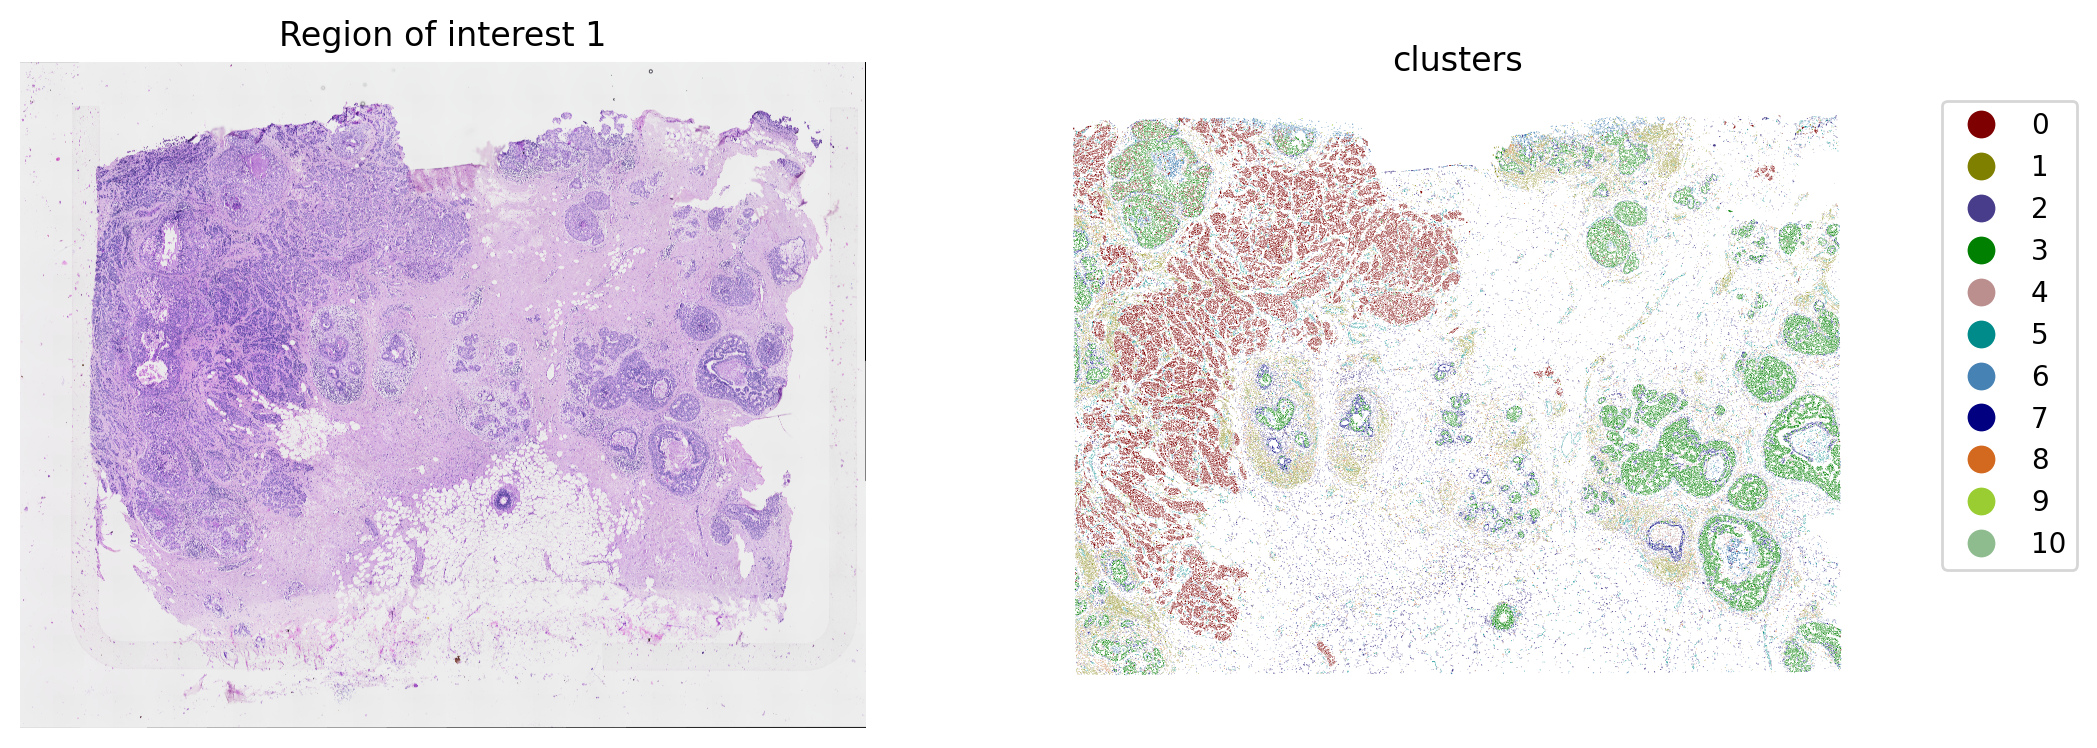

In [28]:
import sys
sys.path.append('../src/utils')
import os
import importlib
import image_plot_utils
importlib.reload(image_plot_utils)
from image_plot_utils import plot_clusters_and_save_image
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [27]:
merged_gdf = gdf.merge(count_area_filtered_adata.obs['clusters'].astype('category'), left_on='id', right_index=True)

<Axes: >

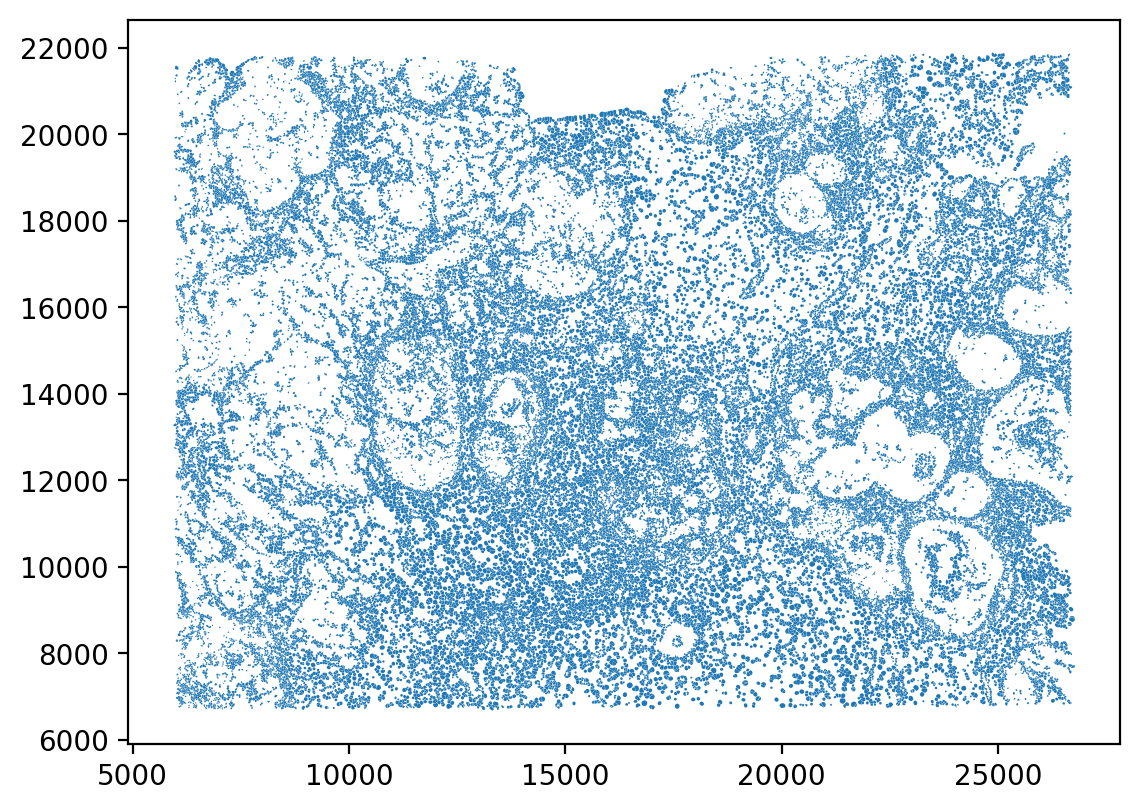

In [28]:
merged_gdf.plot()

In [29]:
merged_gdf_no_clusters = merged_gdf.drop(columns=['clusters'])

In [30]:
import sys
sys.path.append('../src/utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe

In [31]:
cells_data = load_dataframe('../data/xenium/outs/cells.parquet')

In [32]:
cells_data

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  
0        58.387031     26.642188  
1       197.016719     42.130781  
2        16.256250     12.688906  
3        42.311406     10.069844  
4       107.652500     37.479688  
...            ...           ...  
167775  220.452813     60.599688  
167776   37.389375     25.242344  
167777  287.058281     86.700000  
167778  235.354375     25.197188  
167779  270.079531    111.806875  

[167780 rows x 9 columns]

In [33]:
import numpy as np
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = cells_data[['x_centroid', 'y_centroid']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
cells_data[['x_location_transformed', 'y_location_transformed']] = transformed_coords

In [34]:
from shapely.geometry import Polygon, Point
# Create a GeoDataFrame from cells_data
geometry = [Point(xy) for xy in zip(cells_data['x_location_transformed'], cells_data['y_location_transformed'])]
cells_gdf = gpd.GeoDataFrame(cells_data, geometry=geometry)
cells_gdf.crs = None

In [35]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

<Axes: >

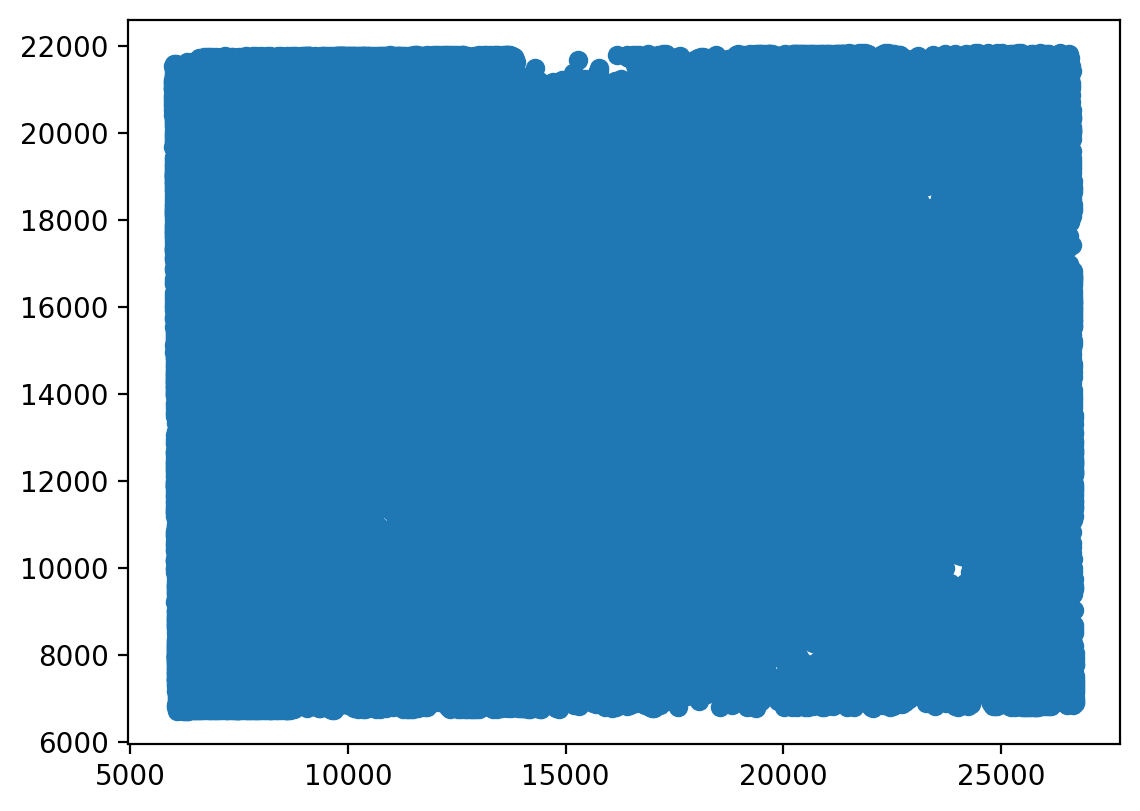

In [38]:
cells_gdf.plot()

In [36]:
# Perform spatial join
joined = gpd.sjoin(merged_gdf_no_clusters, cells_gdf, how='left', predicate='intersects')

<Axes: >

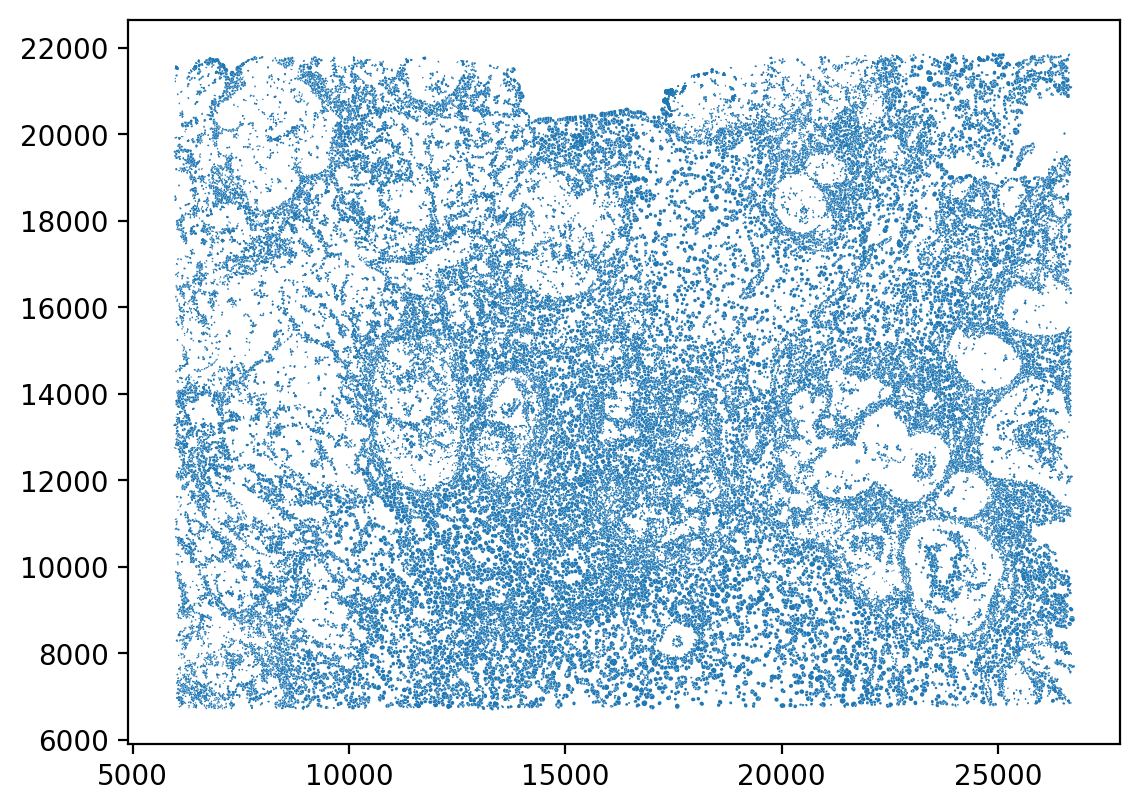

In [37]:
joined.plot()

In [38]:
joined

id                                           geometry   
17074      ID_17075  POLYGON ((7166.349 6941.457, 7166.383 6941.279...  \
17090      ID_17091  POLYGON ((7152.634 6784.167, 7153.516 6784.906...   
17092      ID_17093  POLYGON ((7133.757 6724.244, 7128.917 6722.310...   
17151      ID_17152  POLYGON ((7074.632 6770.091, 7074.333 6770.190...   
17154      ID_17155  POLYGON ((7150.150 6802.794, 7145.817 6852.657...   
...             ...                                                ...   
1065369  ID_1065370  POLYGON ((24867.036 21240.937, 24868.239 21242...   
1065371  ID_1065372  POLYGON ((24282.607 21077.181, 24282.362 21077...   
1065372  ID_1065373  POLYGON ((24281.691 21106.329, 24281.628 21106...   
1065373  ID_1065374  POLYGON ((24713.655 21357.139, 24713.351 21357...   
1065374  ID_1065375  POLYGON ((24752.289 21389.583, 24753.340 21390...   

         index_right   cell_id   x_centroid   y_centroid  transcript_counts   
17074        42649.0   42650.0   398.619987  5397.414087              233.0  \
17090         3240.0    3241.0   410.744731  5458.798364              160.0   
17092         3239.0    3240.0   393.682657  5465.328589              193.0   
17151        42271.0   42272.0   374.758250  5447.091357              197.0   
17154        42280.0   42281.0   409.853253  5431.781812              120.0   
...              ...       ...          ...          ...                ...   
1065369          NaN       NaN          NaN          NaN                NaN   
1065371          NaN       NaN          NaN          NaN                NaN   
1065372          NaN       NaN          NaN          NaN                NaN   
1065373     150717.0  150718.0  6830.294116   176.534129              399.0   
1065374          NaN       NaN          NaN          NaN                NaN   

         control_probe_counts  control_codeword_counts  total_counts   
17074                     0.0                      0.0         233.0  \
17090                     0.0                      0.0         160.0   
17092                     1.0                      0.0         194.0   
17151                     0.0                      0.0         197.0   
17154                     0.0                      0.0         120.0   
...                       ...                      ...           ...   
1065369                   NaN                      NaN           NaN   
1065371                   NaN                      NaN           NaN   
1065372                   NaN                      NaN           NaN   
1065373                   1.0                      0.0         400.0   
1065374                   NaN                      NaN           NaN   

           cell_area  nucleus_area  x_location_transformed   
17074     415.076250     45.156250             7132.963852  \
17090     218.511094     28.312969             7167.103328   
17092     714.913750     58.296719             7120.306008   
17151     174.167656     21.720156             7068.059546   
17154     101.466094     10.611719             7164.291874   
...              ...           ...                     ...   
1065369          NaN           NaN                     NaN   
1065371          NaN           NaN                     NaN   
1065372          NaN           NaN                     NaN   
1065373  1064.468281     23.390937            24736.609037   
1065374          NaN           NaN                     NaN   

         y_location_transformed  
17074               6932.240057  
17090               6763.724955  
17092               6745.552122  
17151               6795.412684  
17154               6837.951629  
...                         ...  
1065369                     NaN  
1065371                     NaN  
1065372                     NaN  
1065373            21364.786294  
1065374                     NaN  

[65565 rows x 14 columns]

In [39]:
filtered_joined = joined[~joined['index_right'].isna()]

In [40]:
filtered_joined

id                                           geometry   
17074      ID_17075  POLYGON ((7166.349 6941.457, 7166.383 6941.279...  \
17090      ID_17091  POLYGON ((7152.634 6784.167, 7153.516 6784.906...   
17092      ID_17093  POLYGON ((7133.757 6724.244, 7128.917 6722.310...   
17151      ID_17152  POLYGON ((7074.632 6770.091, 7074.333 6770.190...   
17154      ID_17155  POLYGON ((7150.150 6802.794, 7145.817 6852.657...   
...             ...                                                ...   
1065329  ID_1065330  POLYGON ((25098.306 21683.966, 25098.852 21683...   
1065354  ID_1065355  POLYGON ((24640.006 21454.214, 24640.797 21454...   
1065364  ID_1065365  POLYGON ((24261.430 21199.155, 24261.398 21199...   
1065365  ID_1065366  POLYGON ((25110.778 21073.804, 25110.744 21074...   
1065373  ID_1065374  POLYGON ((24713.655 21357.139, 24713.351 21357...   

         index_right   cell_id   x_centroid   y_centroid  transcript_counts   
17074        42649.0   42650.0   398.619987  5397.414087              233.0  \
17090         3240.0    3241.0   410.744731  5458.798364              160.0   
17092         3239.0    3240.0   393.682657  5465.328589              193.0   
17151        42271.0   42272.0   374.758250  5447.091357              197.0   
17154        42280.0   42281.0   409.853253  5431.781812              120.0   
...              ...       ...          ...          ...                ...   
1065329     151002.0  151003.0  6949.038037    78.380879              193.0   
1065354     150979.0  150980.0  6795.193433   155.822551              352.0   
1065364     151038.0  151039.0  6663.566699   236.138524              318.0   
1065365     150743.0  150744.0  6977.615967   287.760564              223.0   
1065373     150717.0  150718.0  6830.294116   176.534129              399.0   

         control_probe_counts  control_codeword_counts  total_counts   
17074                     0.0                      0.0         233.0  \
17090                     0.0                      0.0         160.0   
17092                     1.0                      0.0         194.0   
17151                     0.0                      0.0         197.0   
17154                     0.0                      0.0         120.0   
...                       ...                      ...           ...   
1065329                   0.0                      0.0         193.0   
1065354                   0.0                      0.0         352.0   
1065364                   0.0                      0.0         318.0   
1065365                   0.0                      0.0         223.0   
1065373                   1.0                      0.0         400.0   

           cell_area  nucleus_area  x_location_transformed   
17074     415.076250     45.156250             7132.963852  \
17090     218.511094     28.312969             7167.103328   
17092     714.913750     58.296719             7120.306008   
17151     174.167656     21.720156             7068.059546   
17154     101.466094     10.611719             7164.291874   
...              ...           ...                     ...   
1065329   282.226562     13.953281            25061.590361   
1065354   789.557031     22.894219            24639.878755   
1065364   801.568594      5.373594            24279.257982   
1065365   515.774688      9.121562            25142.923187   
1065373  1064.468281     23.390937            24736.609037   

         y_location_transformed  
17074               6932.240057  
17090               6763.724955  
17092               6745.552122  
17151               6795.412684  
17154               6837.951629  
...                         ...  
1065329            21636.091025  
1065354            21421.229486  
1065364            21198.767183  
1065365            21061.120617  
1065373            21364.786294  

[51622 rows x 14 columns]

<Axes: >

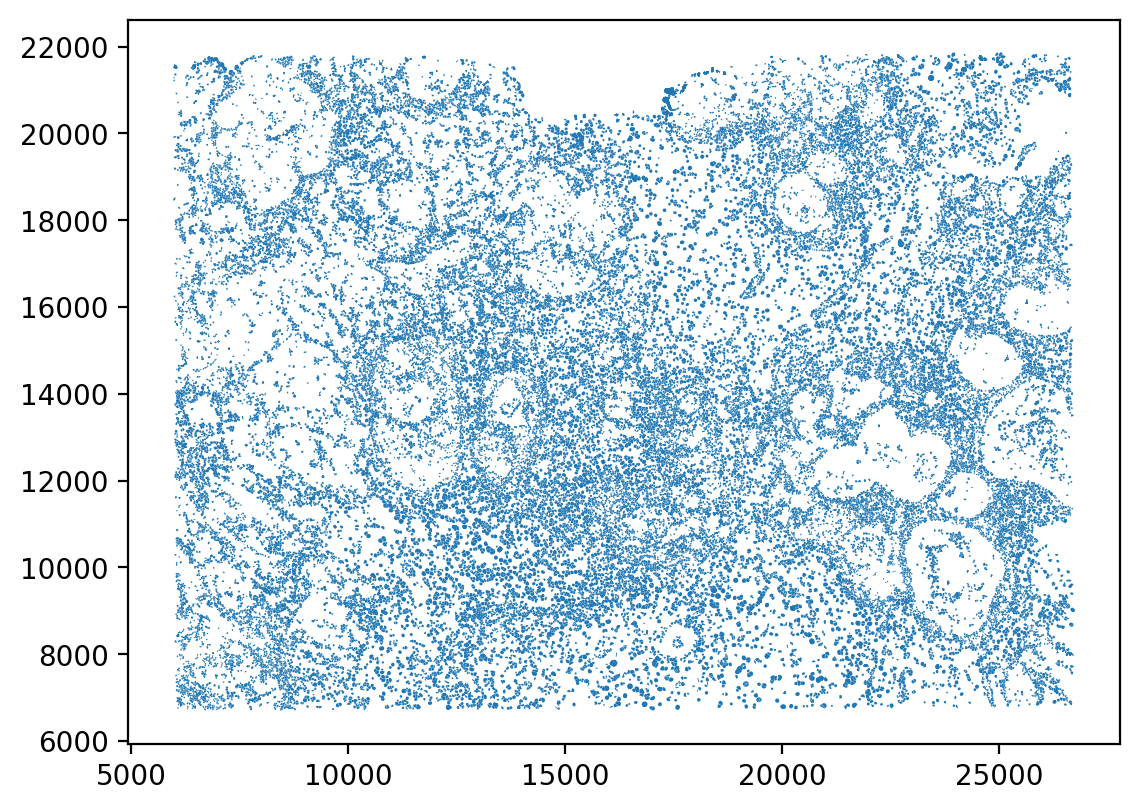

In [41]:
filtered_joined.plot()

In [42]:
import pandas as pd

# Group by 'id' and aggregate 'cell_id' by joining with a comma for duplicates
aggregated_df = filtered_joined.groupby('id').agg({
    'geometry': 'first',  # Keep the first geometry (assuming it's the same for duplicates)
    'cell_id': lambda x: ','.join(x.astype(str))  # Combine cell_id values with a comma
}).reset_index()

aggregated_df

id                                           geometry   
0      ID_1000032  POLYGON ((10092.899 21577.188, 10048.146 21583...  \
1      ID_1000075  POLYGON ((7767.590 20892.370, 7769.455 20893.5...   
2      ID_1000195  POLYGON ((8874.345 20871.906, 8906.188 20888.0...   
3      ID_1000218  POLYGON ((8855.535 20876.263, 8834.013 20904.7...   
4      ID_1000352  POLYGON ((8538.995 21229.913, 8538.846 21229.8...   
...           ...                                                ...   
44622   ID_999843  POLYGON ((9189.320 21413.999, 9189.454 21413.6...   
44623   ID_999848  POLYGON ((9126.435 21394.315, 9133.151 21376.3...   
44624   ID_999849  POLYGON ((9172.168 21356.987, 9171.611 21358.5...   
44625   ID_999852  POLYGON ((9109.716 21461.443, 9111.454 21462.7...   
44626    ID_99993  POLYGON ((7185.932 7842.721, 7173.616 7850.288...   

               cell_id  
0              44225.0  
1              15561.0  
2              44769.0  
3      44764.0,44760.0  
4              47126.0  
...                ...  
44622          44947.0  
44623          47381.0  
44624          44949.0  
44625  47391.0,47388.0  
44626          39840.0  

[44627 rows x 3 columns]

In [43]:
# Count the number of cell_ids by splitting on the comma and checking the length
aggregated_df['cell_id_count'] = aggregated_df['cell_id'].apply(lambda x: len(x.split(',')))

# Filter the rows where the count of cell_ids is greater than 1
rows_with_multiple_cell_ids = aggregated_df[aggregated_df['cell_id_count'] > 1]

# Count how many such rows exist
num_rows_with_multiple_cell_ids = rows_with_multiple_cell_ids.shape[0]

# Display the result
print(f"Number of rows with more than one cell_id: {num_rows_with_multiple_cell_ids}")


Number of rows with more than one cell_id: 5905


In [44]:
filtered_df = aggregated_df[aggregated_df['cell_id_count'] <= 1]

# Drop the 'cell_id_count' column if you no longer need it
filtered_df = filtered_df.drop(columns=['cell_id_count'])

# Display the resulting DataFrame
filtered_df

id                                           geometry  cell_id
0      ID_1000032  POLYGON ((10092.899 21577.188, 10048.146 21583...  44225.0
1      ID_1000075  POLYGON ((7767.590 20892.370, 7769.455 20893.5...  15561.0
2      ID_1000195  POLYGON ((8874.345 20871.906, 8906.188 20888.0...  44769.0
4      ID_1000352  POLYGON ((8538.995 21229.913, 8538.846 21229.8...  47126.0
6      ID_1000428  POLYGON ((9076.972 21252.088, 9076.738 21252.3...  47382.0
...           ...                                                ...      ...
44621   ID_999822  POLYGON ((8930.486 20946.293, 8930.675 20945.8...  44747.0
44622   ID_999843  POLYGON ((9189.320 21413.999, 9189.454 21413.6...  44947.0
44623   ID_999848  POLYGON ((9126.435 21394.315, 9133.151 21376.3...  47381.0
44624   ID_999849  POLYGON ((9172.168 21356.987, 9171.611 21358.5...  44949.0
44626    ID_99993  POLYGON ((7185.932 7842.721, 7173.616 7850.288...  39840.0

[38722 rows x 3 columns]

In [45]:
filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')

<Axes: >

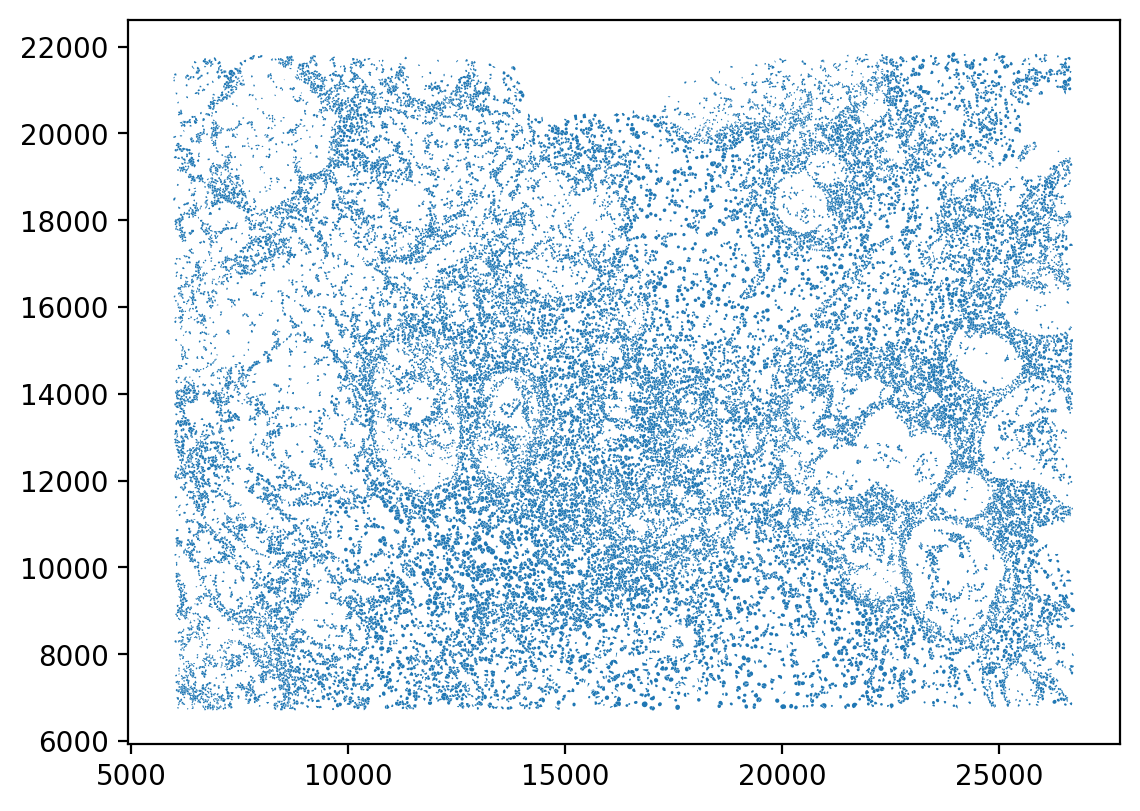

In [46]:
filtered_gdf.plot()

In [47]:
# important use as gdf for id mapping
filtered_gdf.to_file("../data/xenium/outs/final_adatas/filtered_gdf_stardist_buffered07_voronoi.geojson", driver='GeoJSON')

In [48]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 58570 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [49]:
import anndata as ad

# Extract the ids from filtered_gdf
valid_ids = filtered_gdf['id'].tolist()

# Filter the rows in grouped_filtered_adata based on the valid ids
filtered_grouped_adata = grouped_filtered_adata[grouped_filtered_adata.obs['id'].isin(valid_ids)]


In [50]:
filtered_grouped_adata

View of AnnData object with n_obs × n_vars = 38722 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [51]:
filtered_grouped_adata.write("../data/xenium/improved_outs/grouped_filtered_stardist_buffered07_voronoi_adata.h5ad")
# IMPORTANT you will need this as ADATA